The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

The files contain one message per line. Each line is composed by two columns: class (spam or ham) and raw message.

This data will be our labeled training set. Using these ham/spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

## DATA ANALYSIS

#### Imports required packages

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from textblob import TextBlob
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
#reading the data
data = pd.read_csv("spam.csv", encoding = "latin-1")

# data = data[['v1', 'v2']]
# data = data.rename(columns = {'v1': 'label', 'v2': 'text'})

In [50]:
#checking first few rows
data.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [51]:
#removing unnecessary columns

data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)

In [52]:
#again check first few rows of data
display(data.head(n = 5))

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
# Lets look at the dataset info to see if everything is alright

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [54]:
# check the statistics of data
data.groupby('class').describe()

message                                                               
        count unique                                                top freq
class                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
# spam sms - not important sms
# ham sms -  important sms

There are some repetative messages in the data. Lets check the top messages of data to find the most repetative messages

In [55]:
#check the top spam/ham messages

topMessages = data.groupby("message")["class"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 5)
display(topMessages)


,len,max
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham


So. People are really busy it seems. "Sorry, i'll call later" tops the ham message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

Theres a quite lot of Ok..., Okie and Ok. in there too 

#### How long are the messages?

In [56]:
#add new column to the dataframe data to see the length of every message

data['length'] = data['message'].map(lambda text: len(text))
print (data.head())

# message - go until ..... - input text - len(text)

  class                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


<Axes: ylabel='Frequency'>

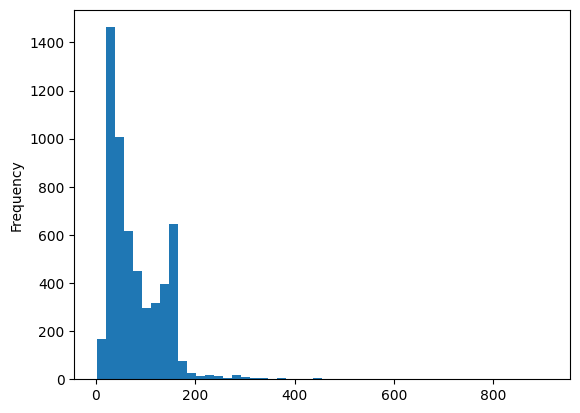

In [59]:
data.length.plot(bins=50, kind='hist')

We can see here maximum messages contains number of words in the range of [0, 200]. 

In [60]:
#check the statistics of the length of the message

data.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

The average length of the message is 80, while the minimum length is 2 and maximun length is 910.

#### Is there any difference in message length between spam and ham?

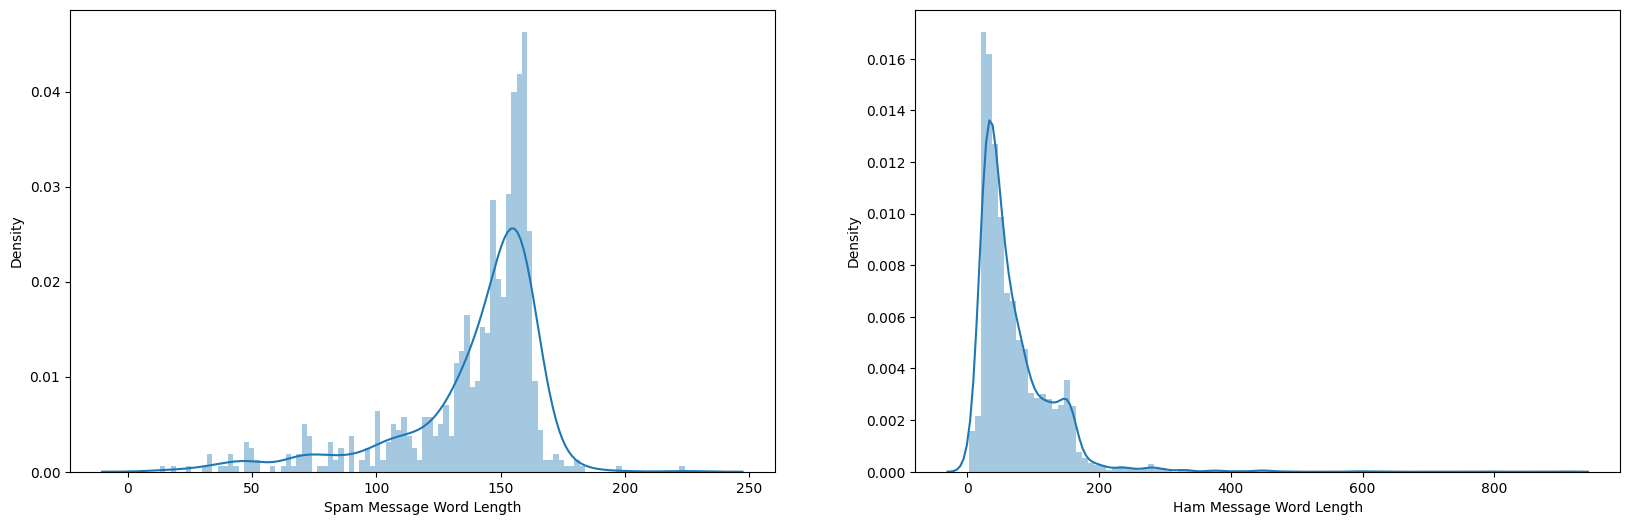

In [62]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(data[data["class"] == "spam"]["length"], bins = 100, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(data[data["class"] == "ham"]["length"], bins = 100, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

Looks like spam messages are usually longer. Maybe messageLength can become a feature to predict whether the message is spam/ ham ?

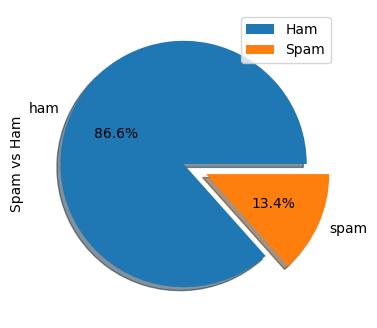

In [64]:
#Check what precentage of our data is spam/ham

data["class"].value_counts().plot(kind = 'pie', explode = [0,0.2], figsize = (4,4), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [63]:
data["class"].value_counts()

class
ham     4825
spam     747
Name: count, dtype: int64

A lot of messages are actually not spam. About 87% of our dataset consists of normal messages.

While we split our data set into train and test or when we use cross validation, we will have to use stratified sampling, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy.

A very basic model would be a model that predicts everything as ham. It would have a decent accuracy. But then again, is that right? No. We will then have to use an accuracy metric that keeps this in mind. Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. 

In [65]:
#Study individual Spam/ham words

# ham-4000 + spam-1000 = 5000 - 80:20
# train , test = 4000 , 1000
# 3200 - ham , 800 - spam  = 80:20
# test - 200 -spam, 800 - ham = 80: 20

# spam classifed as ham - Inbox 
# ham classifed as spam - Spam - user may neglect

# metrics - Precision tp/tp + fp


spam_messages = data[data["class"] == "spam"]["message"]
ham_messages = data[data["class"] == "ham"]["message"]

spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

In [69]:
len(spam_words)

len([word for word in spam_words if word == 'call'])

346

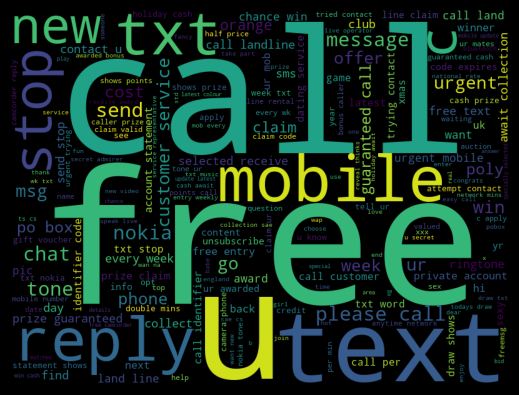

In [70]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=800, height=600).generate(" ".join(spam_words))
plt.figure( figsize=(5,5), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

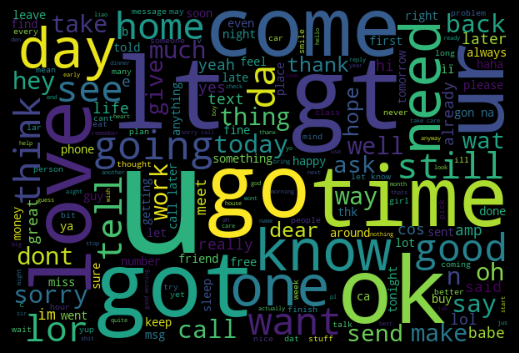

In [71]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(5,5), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [72]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      219
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
Name: count, dtype: int64

In [73]:
# Top 10 Ham words

ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       989
gt      318
lt      316
get     301
ok      261
go      248
got     242
ur      237
know    236
like    231
Name: count, dtype: int64

## Data Preprocessing

Cleaning textual data is a little different than regular data cleaning. There is a much heavier emphasis on text normalisation than removing outliers or leverage points. 

When used correctly, it reduces noise, groups terms with similar semantic meanings and reduces computational costs by giving us a smaller matrix to work with.

There are many types of Text Normalization.Like Case normalisation, Removing stop words, Removing punctuations and special symbols, Lemmatising/Stemming etc.

For this particular classification problem, we will use case normalisation and removing stop wordds.

In [74]:
def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
#     words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    message = message.lower()
    
    return message

data["message"] = data["message"].apply(cleanText)
data.head(n = 10)    

,class,message,length
0,ham,go until jurong point crazy available only in ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor u c already then say,49
4,ham,nah i dont think he goes to usf he lives aroun...,61
5,spam,freemsg hey there darling its been 3 weeks now...,148
6,ham,even my brother is not like to speak with me t...,77
7,ham,as per your request melle melle oru minnaminun...,160
8,spam,winner as a valued network customer you have b...,158
9,spam,had your mobile 11 months or more u r entitled...,154


In [ ]:
# Bag of words

# sent1 = "My name is Omkar"                                 -   my    tf - 1/4 , idf  = log(3/2)  tfidf =  (1/4) * log(3/2)
# sent2 = " I am  Data Scientist"
# sent3 = "My passion is Data Science"
# sent4 = "My job is in Computer vison domain"                 [0.041 0.12 0.03 0.02 0.19 0.21 0.14]


# total vocab 20
# unique words 15
# unique_words = ['my', 'name', 'is', 'omkar', 'i', am, passion, data, science, scientist, job, computer, vision, in, domain]
# # vector 16
# word - present - 1, word  not present 0

# sent1 = [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
# sent2 = [0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0]
# sent3 = [1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]
# sent4 = [1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1]

# vector 1 million size.....lacs 

#tfidf -  term frequence invserde document frequencu

# tf = frqucy of i in doc j/ total no words in doc j
# idf = log(total no of docs/ num of times term occured)

# tf (my) = 1/4 for sent 1
# idf (my) = log(4/3)

# tf idf (my) =  1/4 * log(4/3)

In [ ]:
# tf -idf  (my) =  (1/4) * log(4/3)  = 0.0410

In [ ]:
# tf- tdf (computer) = (1/4) * log(4/1)  = 0.1980  # more weightage less ocuuring word "computer" comapre to multiple occuring "my"

In [ ]:
# word - low freq - high log value - tfidf more
# word - high frew - low log value - tfodf less

# the are is this - less weightage
# more weightage

In [ ]:
# # log (1000) =  3
# log (100) =  2
# log(10) = 1
# log(1) = 0

In [ ]:
# weightage (tfidf_computer ) >>>> weighatage (tfidf_my)

In [ ]:
# (1/7)*np.log(4/1)

In [ ]:
# is are the was there........................................ high freq in data
# Purpose tfidf - more  weightage to less occuring words in your - low weight high frquency

#### Convert our clean text into a representation that a machine learning model can understand. We will use the Tfifd for this.

Now we will convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Here we will use the TF-IDF vectorizer (Term Frequency — Inverse Document Frequency), an embedding technique which takes into account the importance of each term to document.

TF-IDF vectorizes documents by calculating a TF-IDF statistic between the document and each term in the vocabulary. The document vector is constructed by using each statistic as an element in the vector.

The TF-IDF statistic for term i in document j is calculated as follows:

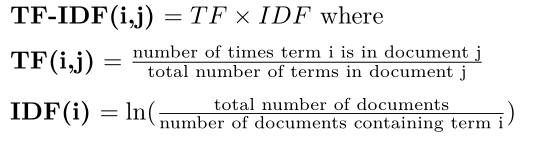

In [75]:
#specifing features and labels
labels = data['class']
text = data['message']

In [ ]:
# org 87% ham 13% spam  --  train test val -  same proportion of labels in all train test val - train 87% ham 13% spam

In [78]:
#splitting data into three sets - train, test and validation - 70 15 15

X_train, X_remain, y_train, y_remain = train_test_split(text, labels, stratify = labels, random_state=0, test_size=0.3)

X_test, X_val, y_test, y_val = train_test_split(X_remain,y_remain,stratify = y_remain, random_state = 0, test_size = 0.5)

In [79]:
#check the shape of all three datasets

print("Training Data:",X_train.shape,y_train.shape )

print("Testing Data:", X_test.shape,y_test.shape)

print("Validation Data:", X_val.shape,y_val.shape )

Training Data: (3900,) (3900,)
Testing Data: (836,) (836,)
Validation Data: (836,) (836,)


In [82]:
#The CountVectorizer provides a simple way to 
#both tokenize a collection of text documents and build a vocabulary of known words, 
#but also to encode new documents using that vocabulary.

# create the transform
count_vec = CountVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return document- term matrix.
X_train_counts = count_vec.fit_transform(X_train)
# print(X_train_counts)

# (document term) frequency

In [86]:
len(count_vec.vocabulary_)

7427

In [87]:
#Learn vocabulary and idf from training set.
tf_transformer = TfidfTransformer().fit(X_train_counts)

# Learn vocabulary and idf, return term-document matrix.
X_train_transformed = tf_transformer.transform(X_train_counts)
# print(X_train_transformed)

# document term tfidf

In [88]:
#test data
X_test_counts = count_vec.transform(X_test)
X_test_transformed = tf_transformer.transform(X_test_counts)

In [89]:
#converts classes into integer
labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

In [90]:
np.unique(y_train_lables_trf)

array([0, 1])

In [91]:
#label mapping of integer to class
label_mapping = dict(zip(labels.classes_,labels.transform(labels.classes_)))
print(label_mapping)

{'ham': 0, 'spam': 1}


# Model Building

In [92]:
model = MultinomialNB()

clf = model.fit(X_train_transformed,y_train_lables_trf)

prediction = clf.predict(X_test_transformed)

In [94]:
# prediction

#### Precision

Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. It is also called the Positive Predictive Value (PPV).


#### Recall

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate.


#### F1 Score

The F1 Score is the 2*((precision*recall)/(precision+recall)). It is also called the F Score or the F Measure. Put another way, the F1 score conveys the balance between the precision and the recall.

## Validation and Prediction

In [95]:
#Check accuracy on test data
print('Average accuracy on test set={}'.format(np.mean(prediction == labels.transform(y_test))))

Average accuracy on test set=0.9629186602870813


In [99]:
# labels.transform(y_test)

In [96]:
print ('Accuracy', accuracy_score(labels.transform(y_test), prediction))
print()
results = confusion_matrix(labels.transform(y_test), prediction)
print(results)
print()
print ('Report:')
print (classification_report(labels.transform(y_test), prediction)) 

Accuracy 0.9629186602870813

[[724   0]
 [ 31  81]]

Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.72      0.84       112

    accuracy                           0.96       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.96      0.96      0.96       836



## Deployment

In [100]:
weights = 'spam_detection_mnb.sav'
pickle.dump(clf,open(weights,'wb'))

vocab = 'vocabulary_mnb.sav'
pickle.dump(count_vec, open(vocab, 'wb'))

tfidf = 'tfidf_mnb.sav'
pickle.dump(tf_transformer,open(tfidf,'wb'))

In [101]:
import os
import pickle
MODEL_DIR = os.path.dirname(os.path.abspath("__file__")) #absolute path for model
print(MODEL_DIR)

with open(os.path.join(MODEL_DIR,'spam_detection_mnb.sav'),'rb') as model_file:
    model = pickle.loads(model_file.read())

with open(os.path.join(MODEL_DIR,'tfidf_mnb.sav'),'rb') as tfidf_file:
    tfidf = pickle.loads(tfidf_file.read())
    
with open(os.path.join(MODEL_DIR,'vocabulary_mnb.sav'),'rb') as vocab_file:
    vocab = pickle.loads(vocab_file.read())

label_mapping = { 0 : 'ham', 1 : 'spam'}

d:\Data_Science_Notes\Machine_learning\Chapter_7_Naive_Bayes


In [ ]:
# get vocab of new sms - unique num - tfidf - model - prediction

In [131]:
message = input("SMS:")
data = [message]
data

['offer has finished now']

In [132]:
vocab.transform(data).toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [133]:
intent = model.predict(vocab.transform(data).toarray())
print(intent)
print(f"Input SMS: {message} Label:", label_mapping[intent[0]])

[0]
Input SMS: offer has finished now Label: ham
